In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
import datetime
import geopandas as gpd

In [2]:
year = 2021
df = pd.read_csv(os.path.join(str(year), "./chicago_taxi.csv"))
n_orig_samples = len(df)
print("There are {} data points".format(len(df)))
df.columns

There are 3948045 data points


Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

In [3]:
df.isna().sum(0)

Trip ID                             0
Taxi ID                           368
Trip Start Timestamp                0
Trip End Timestamp                745
Trip Seconds                     1689
Trip Miles                        517
Pickup Census Tract           2804532
Dropoff Census Tract          2816819
Pickup Community Area          308919
Dropoff Community Area         464731
Fare                              608
Tips                              608
Tolls                             608
Extras                            608
Trip Total                        608
Payment Type                        0
Company                             0
Pickup Centroid Latitude       307728
Pickup Centroid Longitude      307728
Pickup Centroid Location       307728
Dropoff Centroid Latitude      448906
Dropoff Centroid Longitude     448906
Dropoff Centroid  Location     448906
dtype: int64

Pickup and dropoff census tract are often missing for privacy reason so we will ignore these columns. Pickup Community Area and Dropoff Community area can be imputed based on the latitude and longitude data. Here we use the community area coordinates provided by https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6 

In [4]:
ca = gpd.read_file("./chicago_map.geojson")
ca['area_num_1'] = ca['area_num_1'].astype('int')
ca.head()

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."


In [5]:
df.columns

Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

In [6]:
pickup_df = gpd.GeoDataFrame(df[["Pickup Centroid Longitude", "Pickup Centroid Latitude",
                               "Pickup Community Area"]], 
                             geometry=gpd.points_from_xy(df["Pickup Centroid Longitude"],
                                                         df["Pickup Centroid Latitude"]),
                             crs=4326)

dropoff_df = gpd.GeoDataFrame(df[["Dropoff Centroid Longitude", "Dropoff Centroid Latitude",
                                 "Dropoff Community Area"]], 
                              geometry=\
                                  gpd.points_from_xy(df["Dropoff Centroid Longitude"],
                                                     df["Dropoff Centroid Latitude"]),
                              crs=4326)

pickup_df = gpd.sjoin(ca[["area_num_1", "geometry"]], pickup_df, how='right')
dropoff_df = gpd.sjoin(ca[["area_num_1", "geometry"]], dropoff_df, how='right')

df["Pickup Community Area"] = pickup_df["Pickup Community Area"].values
df["Dropoff Community Area"] = dropoff_df["Dropoff Community Area"].values


Let us do some sanity check to see if the area is imputed correctly based on the pickup and dropoff area that is not missing

In [7]:
print("There are {} mismatches in pickup ca".format((pickup_df["area_num_1"] == \
                                                     pickup_df["Pickup Community Area"])\
    [pickup_df["Pickup Community Area"].isna()].sum()))
print("There are {} mismatches in dropoff ca".format((dropoff_df["area_num_1"] == \
                                                      dropoff_df["Dropoff Community Area"])\
    [dropoff_df["Dropoff Community Area"].isna()].sum()))


There are 0 mismatches in pickup ca
There are 0 mismatches in dropoff ca


According to the website from the chicago government https://www.chicago.gov/content/dam/city/depts/bacp/publicvehicleinfo/Chicabs/chicagotaxiplacard20200629.pdf the basic fare is calculated as follow:

- Base Fare \$3.25 
- Each additional mile \$2.25
- Every 36 seconds of elapsed time \$0.20
- First additional passenger (aged 13 through 64) \$1.00    
    - Each additional passenger \$0.50
- Convenience Fee for electronic payment \$0.50
- Vomit Clean-up Fee \$50.00
- Illinois Airport Departure Tax \$4.00 (for taxi leaving the airports)

Clearly the variable fare is affected by several factors:

- Whether payment is made in cash, or other electronic payment for which \$0.50 is incurred
- Whether pickup / dropoff involves the Chicago airport
- Trip miles 
- Trip seconds

As such we should exclude:
- Fare that is less than \$3.25
- Payment type that involves dispute or no charge
- Short duration trips that are less than a specified threshold (defined below as 1 minute)

There are 11401 rides with fares less than 3.25, making up 0.288775837154845 % of the total rides in 2021


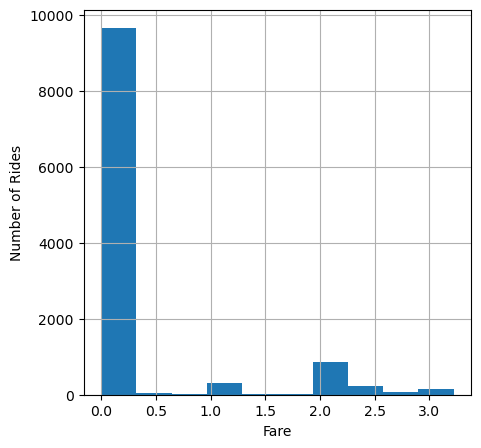

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
low_fare_rides = df[df["Fare"] < 3.25]
print("There are {} rides with fares less than 3.25, making up {} % of the total rides in 2021"\
          .format(len(low_fare_rides), len(low_fare_rides) * 100 / len(df)))
df[df["Fare"] < 3.25].Fare.hist(ax=ax)
ax.set_xlabel("Fare")
ax.set_ylabel("Number of Rides")
df = df[df["Fare"] >= 3.25].reset_index(drop=True)


Weirdly, a significant portion of these low fare rides have 0 fares. Since as a whole they only make up 0.29\% of the entire dataset we can safely discard them. Next we look at the maximum value of these fares



After discarding these low fare rides, we look at trips with duration less than 60 seconds and higher than 2 hours

/home/christopher/miniconda3/envs/taxi_analysis/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Fare'>

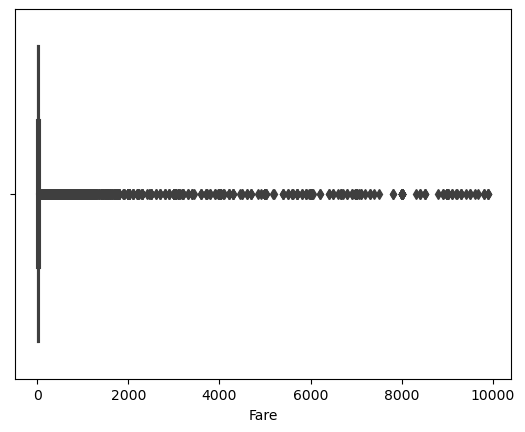

In [13]:
sns.boxplot(df["Fare"])


We see that some of these fares can be absurdly high. According to Schaller consulting http://www.schallerconsult.com/taxi/fares1.htm, an average long trip in Chicago will cost $25.30 anything way beyond this number seems suspicious

Fare 3.25 at 0.0 quantile
Fare 3.5 at 0.05 quantile
Fare 5.0 at 0.1 quantile
Fare 5.75 at 0.15000000000000002 quantile
Fare 6.5 at 0.2 quantile
Fare 7.25 at 0.25 quantile
Fare 8.25 at 0.30000000000000004 quantile
Fare 9.25 at 0.35000000000000003 quantile
Fare 10.1 at 0.4 quantile
Fare 11.5 at 0.45 quantile
Fare 13.75 at 0.5 quantile
Fare 16.5 at 0.55 quantile
Fare 20.25 at 0.6000000000000001 quantile
Fare 24.75 at 0.65 quantile
Fare 28.5 at 0.7000000000000001 quantile
Fare 30.5 at 0.75 quantile
Fare 34.0 at 0.8 quantile
Fare 39.0 at 0.8500000000000001 quantile
Fare 43.5 at 0.9 quantile
Fare 47.0 at 0.9500000000000001 quantile
Fare 9900.25 at 1.0 quantile


Text(0, 0.5, 'Fare')

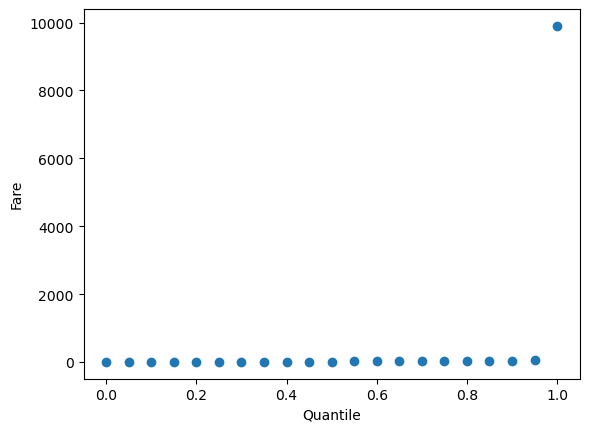

In [11]:
quantiles = np.arange(0, 1.05, 0.05)
fares = [df["Fare"].quantile(q) for q in quantiles]
plt.scatter(quantiles, fares)
for q, fare in zip(quantiles, fares):
    print("Fare {} at {} quantile".format(fare, q))
plt.xlabel('Quantile')
plt.ylabel('Fare')

We see that even at 95% quantile the fare stands only at 47. Here we decide to remove anything that cost larger than 100

In [38]:
df = df[df["Fare"] <= 100]
print("We have {} % data remaining".format(100 * (1 - len(df[df["Fare"] > 100])/ n_orig_samples)))

We have 100.0 % data remaining


Next we look at payment type distribution


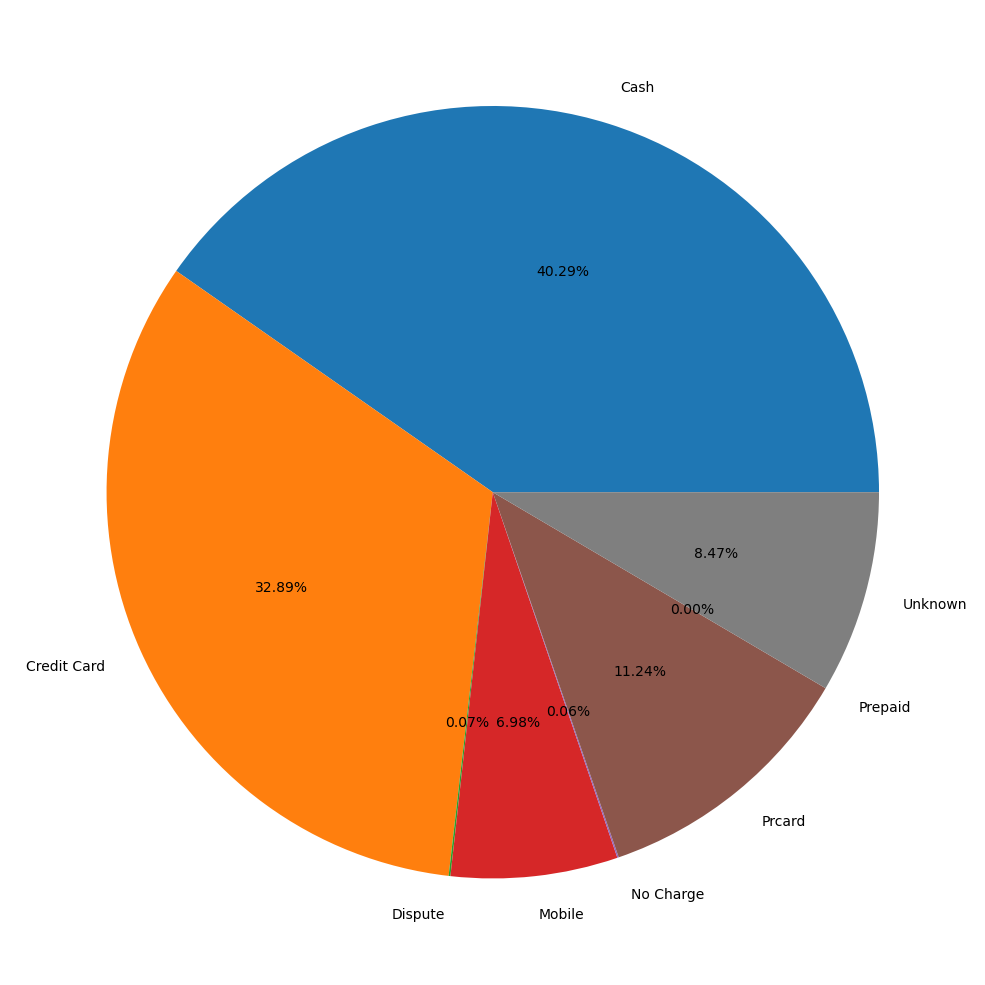

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ptypes, counts = np.unique(df["Payment Type"], return_counts=True)
ax.pie(counts, labels=ptypes, autopct='%1.2f%%')
plt.tight_layout()

8.47 \% of these rides have unknown payment type and since this is a significant portion, of them we should probably keep them. Dispute, no charge and prepaid makes up only a tiny percentage of them so we can safely discard them

In [40]:
df = df[~df["Payment Type"].isin(["Dispute", "No Charge", "Prepaid"])].reset_index(drop=True)
print("After filtering for payment type, we have {}% of the original dataset remaining"\
         .format(len(df)/ n_orig_samples))

After filtering for payment type, we have 0.9935737814538588% of the original dataset remaining


There are 207142 rides with less than 1 minutes ride time, making up 5.280632548103666 % of the remaining rides
There are 7037 rides with greater than 120 minutes ride time, making up 0.17939293451354868 % of the remaining rides


Text(0.5, 1.0, 'Rides with duration more than 2 hours')

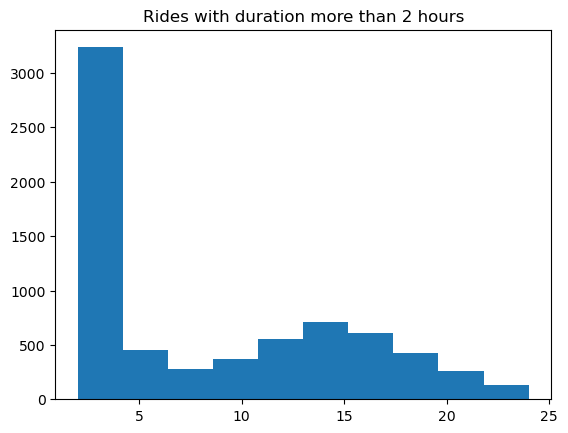

In [41]:
long_duration_rides = df[df["Trip Seconds"] > 2 * 3600]
short_duration_rides = df[df["Trip Seconds"] < 60]

print("There are {} rides with less than 1 minutes ride time, making up {} % of the remaining rides"\
          .format(len(short_duration_rides), len(short_duration_rides) * 100 / len(df)))
print("There are {} rides with greater than 120 minutes ride time, making up {} % of the remaining rides"\
          .format(len(long_duration_rides), len(long_duration_rides) * 100 / len(df)))

plt.hist(long_duration_rides["Trip Seconds"] / 3600)
plt.title('Rides with duration more than 2 hours')

Some rides goes all the way to 24 hours, let's discard these rides from our data

In [42]:
df = df[(df["Trip Seconds"] <= 2 * 3600) & (df["Trip Seconds"] > 60)].reset_index(drop=True)
print("There are {} entries left".format(len(df)))

There are 3673002 entries left


Next we want to filter the dataset based on the missing trip miles information or if the recorded trip miles is 0. Depending on the number of unrecorded trip miles, we might decide to interpolate instead but for now we will remove these data

In [43]:
null_trips = df["Trip Miles"].isna()
zero_miles = df["Trip Miles"] == 0

n_null_trips = null_trips.sum()
n_zero_miles = zero_miles.sum()

print("There are {} rides with null trip miles information, making {} % of the remaining data"\
          .format(n_null_trips, 100 * n_null_trips / len(df)))
print("There are {} rides with zero trip miles, making {} % of the remaining data"\
          .format(n_zero_miles, 100 * n_zero_miles / len(df)))

null_or_zero_miles = df[null_trips | zero_miles].copy() # Saving for later use
df = df[~null_trips & ~zero_miles]

There are 455 rides with null trip miles information, making 0.012387687237850673 % of the remaining data
There are 377597 rides with zero trip miles, making 10.280337446045497 % of the remaining data


We note that there are trips in the data with 0.1 miles total distance (which is roughly 160 meter) and so we allow for the possibility of very short rides in our dataset but we assume that all those rides with zero trip miles are anomalous. Next we calculate the speed of the taxi as well in order to remove more anomalous data points. The speed limit in Chicago varies from 70 mph on interstate highways outside urban areas, 65 mph on rural interstates, 55 mph on interstate highways near or in major cities and on other highways, and 30 mph in uerban area unless some other speed restriction is established (https://www.isp.illinois.gov/TrafficSafety/SpeedLimitEnforcement).

There are 4018 rides with speed greater than 70 mph, which makes up 0.12194418731695474 % of the remaining data


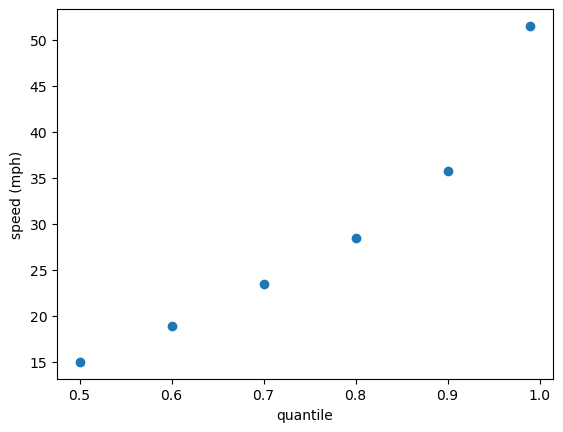

In [44]:
df["Trip mph"] = df["Trip Miles"] * 3600 / df["Trip Seconds"]
quantiles = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
values = [df["Trip mph"].quantile(q)for q in quantiles]
plt.scatter(quantiles, values)
plt.xlabel("quantile")
plt.ylabel("speed (mph)")

speed_limit = 70
rides_beyond_limit = df[df["Trip mph"] > 70]
print("There are {} rides with speed greater than {} mph, which makes up {} % of the remaining data"\
          .format(len(rides_beyond_limit), speed_limit, len(rides_beyond_limit) * 100 / len(df)))


In [45]:
df = df[df["Trip mph"] <= 70].reset_index(drop=True)
print("There are {} rides left, which is {} % of the original dataset"\
          .format(len(df), len(df) * 100 / n_orig_samples))

There are 3290932 rides left, which is 83.35599011662734 % of the original dataset


We try not to be too strict with this speed limit to allow room for error but we see that even the 99 quantile has a speed below 55 mph. We therefore remove any rides with speed greater than 70 mph. We are left with 3295485  rides left, which is still a significant percentage of the original dataset. Next we visualize some of the basic statistics from the dataset. Most of the removal is from those trips with zero miles information but later on we will see during the fare prediction if we can perform some imputation to improve the fare prediction but for the purpose of summarizing the data, we will discard these observations